In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [2]:
def IC(n, case):
    """Initialization"""
    
    u = np.zeros([n,2])     # Contains both velocity and pressure    
    x = np.linspace(0,1,n)
    dx = (x[-1] - x[0])/n
    x_0 = 0.4
    x_bar = 0.075
    p_bar = 0.2    
    
    K_0 = 1
    rho_0 = 1
    
    A = np.zeros([2,2])   # Flux Jacobian
    A[0,1] = K_0
    A[1,0] = 1/rho_0
    
    if(case == "1"):
        
        x_bl = -x_bar + x_0  # left boundary
        x_br = x_bar + x_0   # right boundary
    
        nx_bl = int((x_bl - x[0])/dx)
        nx_br = int((x_br - x[0])/dx)                
        
        u[:nx_bl, 1] = 0
        u[nx_bl:nx_br,1] = p_bar*(1 - ((x[nx_bl:nx_br] - x_0)/x_bar)**2)**0.5
        u[nx_br: ,1] = 0
    
    elif(case == "2"):
        
        x_bl = -x_bar + x_0  # left boundary
        x_br = x_bar + x_0   # right boundary
    
        nx_bl = int((x_bl - x[0])/dx)
        nx_br = int((x_br - x[0])/dx)                
        
        u[:nx_bl, 1] = 0
        u[nx_bl:nx_br,1] = p_bar*(1 - ((x[nx_bl:nx_br] - x_0)/x_bar)**2)**0.5
        u[nx_br: ,1] = 0
    
    u = u.T
    return(x, dx, u, A)

In [3]:
def A_eigen(A):
    """ Calculates the eigen values and eigen vectors of Matrix A """
    [lamda, R] = np.linalg.eig(A)
    R = R/abs(R[1,0])
    idx = np.argsort(lamda)
    lamda = lamda[idx]
    R = R[:,idx]
    return(lamda, R)

In [4]:
[x, dx, u, A] = IC(200,"1")
[lamda, R] = A_eigen(A)
u_initial = copy.deepcopy(u)

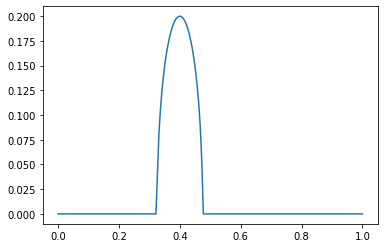

In [5]:
plt.plot(x,u_initial[1,:])

In [6]:
def flux_difference_splitting(u, lamda, R, n, dt, T, case, order):
    
    """ Calculates First or Second order Finite Difference Splitting based on the value of order """
    
    R_inv = np.linalg.inv(R)
    t = 0
    
    diff_u_plus = np.zeros([2,n])
    diff_u_minus = np.zeros([2,n])
    a_coeff_plus = np.zeros([2,n])
    a_coeff_minus = np.zeros([2,n])
    
    new_u = copy.deepcopy(u)

    diff_f_minus_lamda0 = np.zeros([2,n])
    diff_f_minus_lamda1 = np.zeros([2,n])

    diff_f_plus_lamda0 = np.zeros([2,n])
    diff_f_plus_lamda1 = np.zeros([2,n])

    f0 = np.zeros([2,n])
    f1 = np.zeros([2,n])
    
    if (case == 1):
        while (t < T):
        
            diff_u_plus[:,2:] = u[:,2:] - u[:,1:-1]
            diff_u_minus[:,1:-1] = u[:,1:-1] - u[:,0:-2]
        
            for i in range(0,n):
                a_coeff_plus[:,i] = R_inv @ diff_u_plus[:,i]
                a_coeff_minus[:,i] = R_inv @ diff_u_minus[:,i]
        
            for i in range(0,n):
                diff_f_minus_lamda0[:,i] = lamda[0]*(a_coeff_minus[0,i]*R[:,0])
                diff_f_minus_lamda1[:,i] = lamda[1]*(a_coeff_minus[1,i]*R[:,1])
                diff_f_plus_lamda0[:,i] = lamda[0]*(a_coeff_plus[0,i]*R[:,0])
                diff_f_plus_lamda1[:,i] = lamda[1]*(a_coeff_plus[1,i]*R[:,1])
        
            f0 = diff_f_minus_lamda1
            f1 = diff_f_plus_lamda0 
        
            if(order == 1):
                new_u[:,1:-1] = u[:,1:-1] - dt/dx*( f0[:,1:-1] + f1[:,2:] )
            
            elif(order == 2):
                nu_0 = lamda[0]*dt/dx
                nu_1 = lamda[1]*dt/dx
                new_u[:,1:-1] = u[:,1:-1] - dt/dx*( 0.5*(1 + nu_0)*(diff_f_minus_lamda0[:,1:-1]) + 
                                                   0.5*(1 + nu_1)*(diff_f_minus_lamda1[:,1:-1]) + 
                                                   0.5*(1 - nu_0)*(diff_f_plus_lamda0[:,2:]) + 
                                                   0.5*(1 - nu_1)*(diff_f_plus_lamda1[:,2:]))                
                
            new_u[:,0] = new_u[:,1]
            new_u[:,-1] = new_u[:,-2]
            u = copy.deepcopy(new_u)            
            
            t = t + dt 
            
    elif (case == 2):
        d = (x[1] - x[0])
        x_sep = 0.6
        index = int((x_sep - x[0])/d)
        while (t < T):
        
            diff_u_plus[:,2:] = u[:,2:] - u[:,1:-1]
            diff_u_minus[:,1:-1] = u[:,1:-1] - u[:,0:-2]
                        
            for i in range(0,n-1):
                
                if(x[i] < x_sep):
                    a_coeff_plus[:,i] = R_inv @ diff_u_plus[:,i]
                    a_coeff_minus[:,i] = R_inv @ diff_u_minus[:,i]
                    
                elif(x[i] >= x_sep):
                    
                    if(x[i] >= x_sep and x[i-1] < x_sep):
                        
                        K0 = 1
                        rho1 = 1
                        rho2 = 4
                        c1 = (K0/rho1)**0.5
                        c2 = (K0/rho2)**0.5
                        lamda1 = copy.deepcopy(lamda)
                        lamda1[0] = -c1
                        lamda1[1] = c2
                        R1 = copy.deepcopy(R)
                        R1[0,0] = -rho1*c1
                        R1[1,0] = 1
                        R1[0,1] = rho1*c2
                        R1[1,1] = 1
                        R1_inv = np.linalg.inv(R1)
                        
                        a_coeff_plus[:,i] = R1_inv @ diff_u_plus[:,i]
                        a_coeff_minus[:,i] = R1_inv @ diff_u_minus[:,i]
                        
                        a_coeff_plus[:,i] = R1_inv @ diff_u_plus[:,i]
                        a_coeff_minus[:,i] = R1_inv @ diff_u_minus[:,i]                        
                                                
                    else:
                        a_coeff_plus[:,i] = R1_inv @ diff_u_plus[:,i]
                        a_coeff_minus[:,i] = R1_inv @ diff_u_minus[:,i]                        
                        
        
            for i in range(0,index):
                diff_f_minus_lamda0[:,i] = lamda[0]*(a_coeff_minus[0,i]*R[:,0])
                diff_f_minus_lamda1[:,i] = lamda[1]*(a_coeff_minus[1,i]*R[:,1])
                diff_f_plus_lamda0[:,i] = lamda[0]*(a_coeff_plus[0,i]*R[:,0])
                diff_f_plus_lamda1[:,i] = lamda[1]*(a_coeff_plus[1,i]*R[:,1])
            
            for i in range(index,n):
                diff_f_minus_lamda0[:,i] = lamda1[0]*(a_coeff_minus[0,i]*R1[:,0])
                diff_f_minus_lamda1[:,i] = lamda1[1]*(a_coeff_minus[1,i]*R1[:,1])
                diff_f_plus_lamda0[:,i] = lamda1[0]*(a_coeff_plus[0,i]*R1[:,0])
                diff_f_plus_lamda1[:,i] = lamda1[1]*(a_coeff_plus[1,i]*R1[:,1])
        
            f0 = diff_f_minus_lamda1
            f1 = diff_f_plus_lamda0 
            
            if(order == 1):
                new_u[:,1:-1] = u[:,1:-1] - dt/dx*( f0[:,1:-1] + f1[:,2:] )
            
            elif(order == 2):
                nu_0 = lamda[0]*dt/dx
                nu_1 = lamda[1]*dt/dx
                new_u[:,1:index] = u[:,1:index] - dt/dx*( 0.5*(1 + nu_0)*(diff_f_minus_lamda0[:,1:index]) + 0.5*(1 + nu_1)*(diff_f_minus_lamda1[:,1:index]) + 0.5*(1 - nu_0)*(diff_f_plus_lamda0[:,2:index+1]) + 0.5*(1 - nu_1)*(diff_f_plus_lamda1[:,2:index+1]))
                nu_0 = lamda1[0]*dt/dx
                nu_1 = lamda1[1]*dt/dx
                new_u[:,index:-1] = u[:,index:-1] - dt/dx*( 0.5*(1 + nu_0)*(diff_f_minus_lamda0[:,index:-1]) + 0.5*(1 + nu_1)*(diff_f_minus_lamda1[:,index:-1]) + 0.5*(1 - nu_0)*(diff_f_plus_lamda0[:,index+1:]) + 0.5*(1 - nu_1)*(diff_f_plus_lamda1[:,index+1:]))

            new_u[:,0] = new_u[:,1]
            new_u[:,-1] = new_u[:,-2]
            u = copy.deepcopy(new_u)
            
            t = t + dt 

            
    return(u)

In [7]:
dt = 0.004
n = 200

In [8]:
def PLOT(x,u,T):
    plt.plot(x,u[1,:])
    plt.xlabel('x')
    plt.ylabel('P')
    plt.legend(['at t = ' + str(T) + ' sec '])
    plt.title('P vs. X')

# Case I: First Order

### Part 1

In [9]:
R

array([[-1.,  1.],
       [ 1.,  1.]])

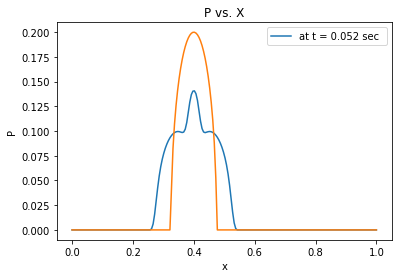

In [10]:
T = 0.052
case = 1
order = 1
u = flux_difference_splitting(u_initial, lamda, R, n, dt, T, case, order);
PLOT(x,u,T)
plt.plot(x,u_initial[1,:])
#plt.savefig("1_1")

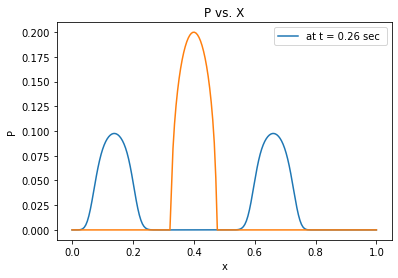

In [11]:
T = 0.26
case = 1
order = 1
u = flux_difference_splitting(u_initial, lamda, R, n, dt, T, case, order);
PLOT(x,u,T)
plt.plot(x,u_initial[1,:])
#plt.savefig("1_2")

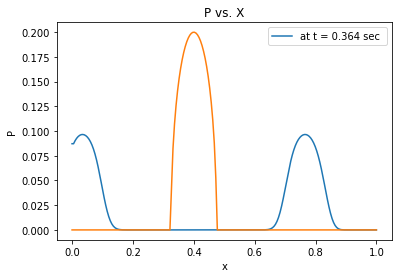

In [12]:
T = 0.364
case = 1
order = 1
u = flux_difference_splitting(u_initial, lamda, R, n, dt, T, case, order);
PLOT(x,u,T)
plt.plot(x,u_initial[1,:])
#plt.savefig("1_3")

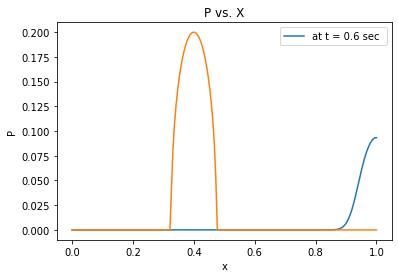

In [13]:
T = 0.6
case = 1
order = 1
u = flux_difference_splitting(u_initial, lamda, R, n, dt, T, case, order);
PLOT(x,u,T)
plt.plot(x,u_initial[1,:])
#plt.savefig("1_4")

## Part 2

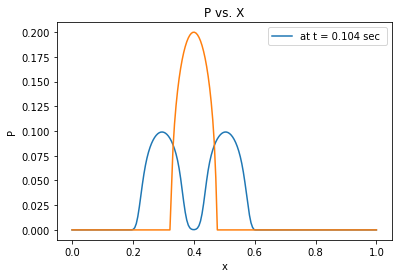

In [14]:
T = 0.104
case = 2
order = 1
u = flux_difference_splitting(u_initial, lamda, R, n, dt, T, case, order);
PLOT(x,u,T)
plt.plot(x,u_initial[1,:])
#plt.savefig("2_1")

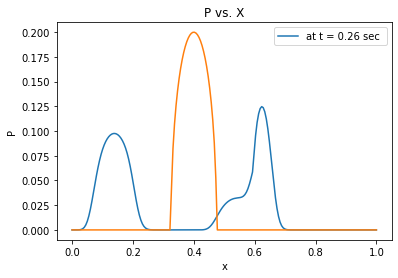

In [15]:
T = 0.26
case = 2
order = 1
u = flux_difference_splitting(u_initial, lamda, R, n, dt, T, case, order);
PLOT(x,u,T)
plt.plot(x,u_initial[1,:])
#plt.savefig("2_2")

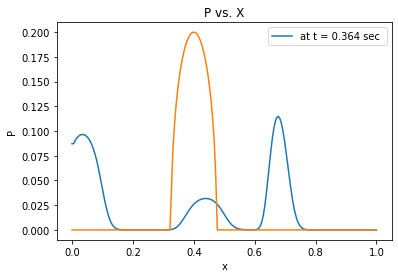

In [16]:
T = 0.364
case = 2
order = 1
u = flux_difference_splitting(u_initial, lamda, R, n, dt, T, case, order);
PLOT(x,u,T)
plt.plot(x,u_initial[1,:])
#plt.savefig("2_3")

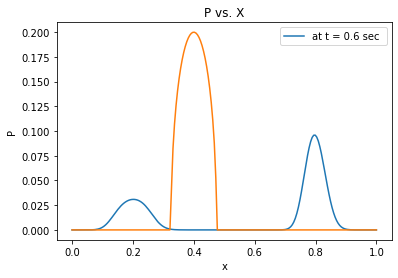

In [17]:
T = 0.6
case = 2
order = 1
u = flux_difference_splitting(u_initial, lamda, R, n, dt, T, case, order);
PLOT(x,u,T)
plt.plot(x,u_initial[1,:])
#plt.savefig("2_4")

# Case II: Second Order

## Part 1

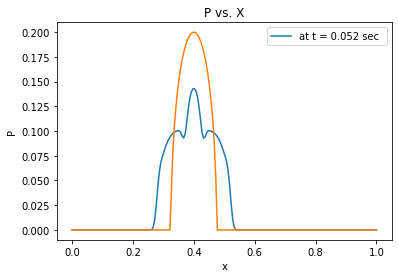

In [18]:
T = 0.052
case = 1
order = 2
u = flux_difference_splitting(u_initial, lamda, R, n, dt, T, case, order);
PLOT(x,u,T)
plt.plot(x,u_initial[1,:])
#plt.savefig("3_1")

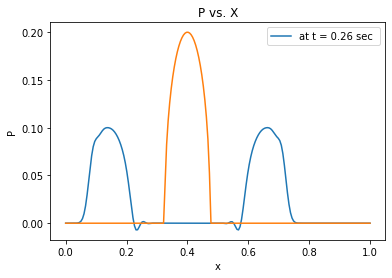

In [19]:
T = 0.26
case = 1
order = 2
u = flux_difference_splitting(u_initial, lamda, R, n, dt, T, case, order);
PLOT(x,u,T)
plt.plot(x,u_initial[1,:])
#plt.savefig("3_2")

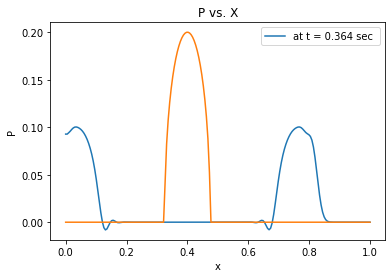

In [20]:
T = 0.364
case = 1
order = 2
u = flux_difference_splitting(u_initial, lamda, R, n, dt, T, case, order);
PLOT(x,u,T)
plt.plot(x,u_initial[1,:])
#plt.savefig("3_3")

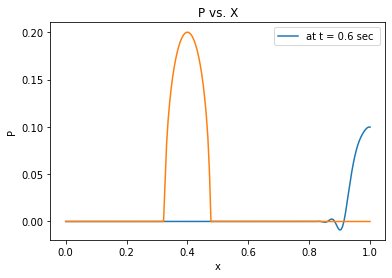

In [21]:
T = 0.6
case = 1
order = 2
u = flux_difference_splitting(u_initial, lamda, R, n, dt, T, case, order);
PLOT(x,u,T)
plt.plot(x,u_initial[1,:])
#plt.savefig("3_4")

## Part 2

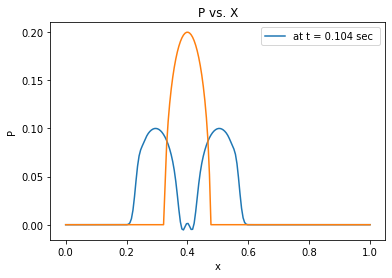

In [22]:
T = 0.104
case = 2
order = 2
u = flux_difference_splitting(u_initial, lamda, R, n, dt, T, case, order);
PLOT(x,u,T)
plt.plot(x,u_initial[1,:])
#plt.savefig("4_1")

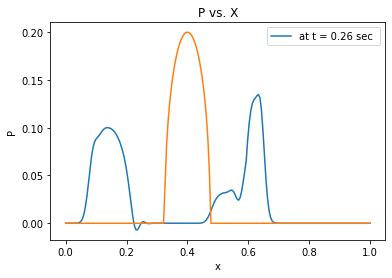

In [23]:
T = 0.26
case = 2
order = 2
u = flux_difference_splitting(u_initial, lamda, R, n, dt, T, case, order);
PLOT(x,u,T)
plt.plot(x,u_initial[1,:])
#plt.savefig("4_2")

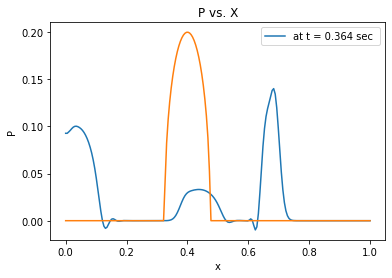

In [24]:
T = 0.364
case = 2
order = 2
u = flux_difference_splitting(u_initial, lamda, R, n, dt, T, case, order);
PLOT(x,u,T)
plt.plot(x,u_initial[1,:])
#plt.savefig("4_3")

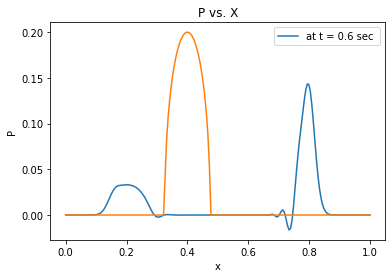

In [25]:
T = 0.6
case = 2
order = 2
u = flux_difference_splitting(u_initial, lamda, R, n, dt, T, case, order);
PLOT(x,u,T)
plt.plot(x,u_initial[1,:])
#plt.savefig("4_4")

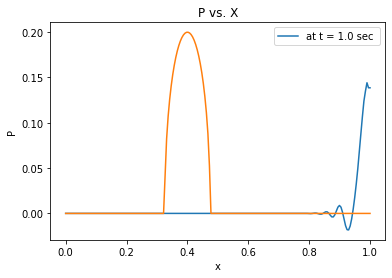

In [26]:
T = 1.0
case = 2
order = 2
u = flux_difference_splitting(u_initial, lamda, R, n, dt, T, case, order);
PLOT(x,u,T)
plt.plot(x,u_initial[1,:])
#plt.savefig("4_5")

## <font color = "green"> Observation:-
## The second order scheme produces numerical oscillations which grow with time

In [27]:
R

array([[-1.,  1.],
       [ 1.,  1.]])

In [28]:
lamda

array([-1.,  1.])

In [29]:
A

array([[0., 1.],
       [1., 0.]])